# UK Road Safety: Supervised Learning Project
This notebook predicts accident severity (Slight, Serious, Fatal) using UK Road Safety Data (STATS19) from data.gov.uk.  
We load, merge, and preprocess data from Accidents, Casualties, and Vehicles datasets, then train multiple for multi-class classification.

Target = 'Collision_severity'
3 = Slight: Minor injuries, not life-threatening (e.g., bruises, sprains).
2 = Serious: More severe injuries, but not fatal (e.g., fractures, hospital admission).
1 = Fatal: At least one person died as a result of the accident.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve,auc, ConfusionMatrixDisplay, brier_score_loss, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import requests
import zipfile
import io
import warnings
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')  # Ignore warnings to keep the output clean.
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


## Load Data
Last 5 years (2020-2024) of Accidents, Casualties, and Vehicles data from CSV URLs.

In [2]:
# Download and load the Accidents dataset
accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv"
accidents_df = pd.read_csv(io.StringIO(requests.get(accidents_url).text), low_memory=False)

# Download and load the Casualties dataset
casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv"
casualties_df = pd.read_csv(io.StringIO(requests.get(casualties_url).text), low_memory=False)

# Download and load the Vehicles dataset
vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv"
vehicles_df = pd.read_csv(io.StringIO(requests.get(vehicles_url).text), low_memory=False)

# Merge all datasets using the 'collision_index' column
df = accidents_df.merge(casualties_df, on='collision_index', how='left', suffixes=('', '_cas'))
df = df.merge(vehicles_df, on='collision_index', how='left', suffixes=('', '_veh'))

# Free up memory by deleting the original dataframes
del accidents_df, casualties_df, vehicles_df
import gc
gc.collect()

10

## Exploratory Data Analysis (EDA)
Explore the distribution of the target variable and key features to understand class balance and data characteristics.

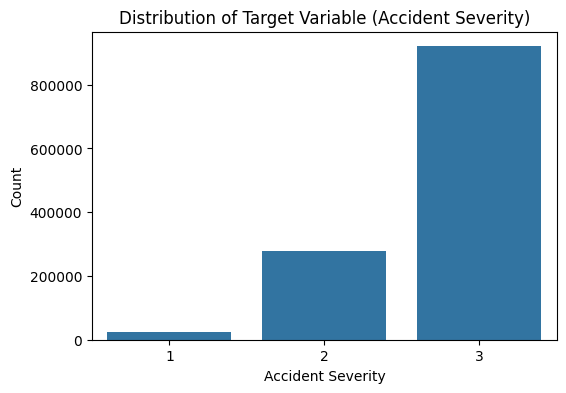

collision_severity
3    920089
2    277034
1     24164
Name: count, dtype: int64


In [19]:
# Visualise the distribution of accident severity in the dataset
plt.figure(figsize=(6,4))
sns.countplot(x='collision_severity', data=df)
plt.title('Distribution of Target Variable (Accident Severity)')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()

# Print the count of each severity class
print(df['collision_severity'].value_counts())

collision_severity,1,2,3
year,,,
2020,4231,44828,171376
2021,4668,53071,188575
2022,5129,59465,193606
2023,5151,59568,188180
2024,4985,60102,178352


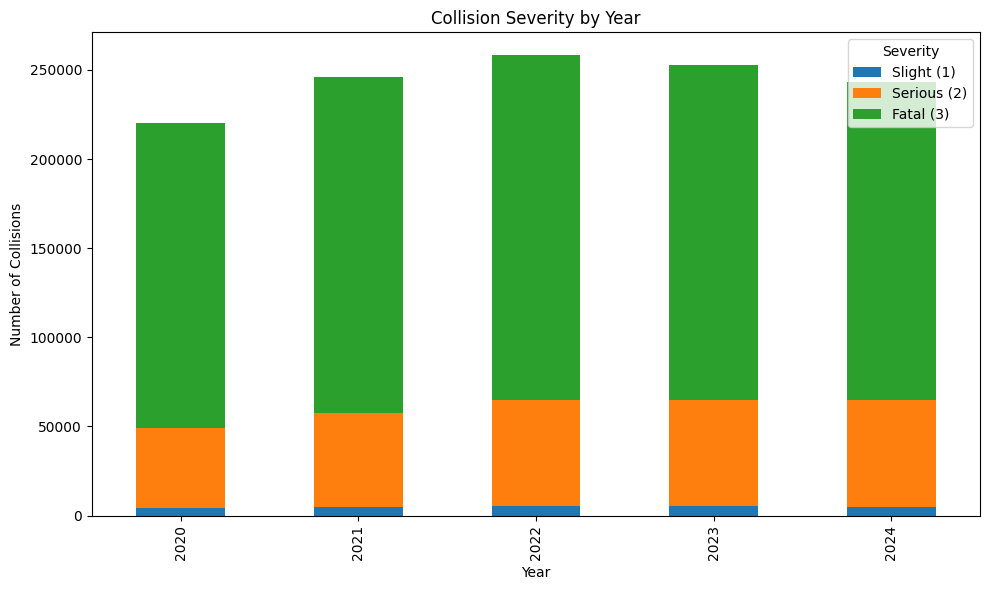

In [4]:
# Show a table and chart of accident severity counts for each year
if 'date' in df.columns:
    # Extract the year from the 'date' column (expects format like YYYY-MM-DD)
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    severity_year_table = pd.crosstab(df['year'], df['collision_severity'])
    display(severity_year_table)
    severity_year_table.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title('Collision Severity by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Collisions')
    plt.legend(title='Severity', labels=['Slight (1)', 'Serious (2)', 'Fatal (3)'])
    plt.tight_layout()
    plt.show()
else:
    print("No 'date' column found in the dataset to extract year.")

## Verify Features and Target
Validate features and target, inspect missing values, data types, and target distribution.

In [5]:
# Verify all features and target in the entire dataset
target = 'collision_severity'

print(f"Total columns in dataset: {len(df.columns)}")
print(f"Total rows in dataset: {len(df)}")

print("\nMissing values across all columns:")
missing_info = df.isnull().sum()
print(missing_info[missing_info > 0]) if missing_info.sum() > 0 else print("No missing values found.")

print("\nData types of all columns:")
print(df.dtypes)

if target in df.columns:
    print("\nTarget distribution:")
    print(df[target].value_counts())
else:
    print(f"\nWarning: Target column '{target}' not found in dataset.")

Total columns in dataset: 98
Total rows in dataset: 1221287

Missing values across all columns:
location_easting_osgr              144
location_northing_osgr             144
longitude                          144
latitude                           144
local_authority_highway_current    217
dtype: int64

Data types of all columns:
collision_index             object
collision_year               int64
collision_ref_no            object
location_easting_osgr      float64
location_northing_osgr     float64
                            ...   
driver_imd_decile            int64
lsoa_of_driver              object
escooter_flag                int64
driver_distance_banding      int64
year                         int32
Length: 98, dtype: object

Target distribution:
collision_severity
3    920089
2    277034
1     24164
Name: count, dtype: int64


## Handle Outliers
Detect and cap outliers in numerical features using the IQR method to prevent model skewing.

In [6]:
# Drop unnecessary columns (identifiers, redundant info, or columns with too many missing values)
# Drop columns that are clearly not predictive or are unique identifiers
# Drop leaky features (anything containing 'severity' or 'adjusted' that isn't the target)

target = 'collision_severity'
cols_to_drop = [
    'accident_index', 'accident_reference', 'collision_index', 'collision_reference',
    'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude',
    'lsoa_of_accident_location', 'local_authority_highway', 'collision_ref_no',
    'collision_ref_no_cas', 'collision_ref_no_veh', 'lsoa_of_casualty', 'lsoa_of_driver'
]

# Identify leaky features and identifiers dynamically
leaky_or_id_cols = [
    col for col in df.columns 
    if (('severity' in col.lower() or 'adjusted' in col.lower() or 'ref' in col.lower() or 'no' in col.lower()) 
        and col != target)
]
cols_to_drop.extend(leaky_or_id_cols)

# Also drop columns with more than 50% missing values
threshold = 0.5
missing_info = df.isnull().mean()
high_missing_cols = missing_info[missing_info > threshold].index.tolist()
cols_to_drop.extend(high_missing_cols)

# Remove duplicates in the list and drop from df
cols_to_drop = list(set([c for c in cols_to_drop if c in df.columns]))
print(f"Dropping {len(cols_to_drop)} unnecessary/leaky/high-missing columns.")
df = df.drop(columns=cols_to_drop)

# Identify all numerical features in the remaining dataset for outlier detection
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target and any remaining ID-like columns
features_to_exclude = [target] + [col for col in df.columns if 'id' in col.lower() or 'index' in col.lower()]
numerical_features = [col for col in numerical_features if col not in features_to_exclude]

print(f"\nNumerical features identified for outlier handling: {numerical_features}")

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outlier values to the IQR bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print("\nOutlier handling (IQR capping) complete for all numerical features.")


Dropping 24 unnecessary/leaky/high-missing columns.

Numerical features identified for outlier handling: ['collision_year', 'police_force', 'number_of_vehicles', 'number_of_casualties', 'day_of_week', 'local_authority_district', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail_historic', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control_historic', 'pedestrian_crossing_physical_facilities_historic', 'pedestrian_crossing', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards_historic', 'carriageway_hazards', 'urban_or_rural_area', 'trunk_road_flag', 'collision_injury_based', 'collision_year_cas', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty', 'pedestrian_location', 'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'casualty_type', 'ca

## Feature Selection

Create new features, binning of features and identifying top 20 most predictive features using XGBoost. Then information value for serious class.

In [7]:
# Feature Engineering and Selection using LightGBM as base
# 1. Feature Engineering
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek

if 'time' in df.columns:
    # Extract hour and minutes from time string (HH:MM)
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]) if isinstance(x, str) and ':' in x else np.nan)
    df['time_minutes'] = df['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) and ':' in x else np.nan)

# Refined Binning
if 'age_of_casualty' in df.columns:
    df['age_bin'] = pd.cut(df['age_of_casualty'], bins=[0, 12, 19, 35, 50, 65, 100], 
                           labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

if 'speed_limit' in df.columns:
    df['speed_bin'] = pd.cut(df['speed_limit'], bins=[0, 20, 30, 40, 50, 60, 70, 100], 
                             labels=['v_low', 'low', 'm_low', 'med', 'm_high', 'high', 'v_high'])

# 2. Prepare for Feature Selection
target = 'collision_severity'
# Drop non-predictive columns created during engineering or original ones
cols_to_exclude = [target, 'date', 'time']
features_all = [col for col in df.columns if col not in cols_to_exclude]

X_sel = df[features_all].copy()
y_sel = df[target].copy()

# Map target for XGBoost (1->0, 2->1, 3->2)
severity_map_fs = {1: 0, 2: 1, 3: 2}
y_sel = y_sel.map(severity_map_fs)

# Handle categorical features for XGBoost
cat_features_all = []
for col in X_sel.columns:
    if X_sel[col].dtype == 'object' or X_sel[col].dtype.name == 'category':
        X_sel[col] = X_sel[col].astype('category').cat.codes
        cat_features_all.append(col)

# 3. Feature Selection using XGBoost Importance
print(f"Running feature selection on {len(features_all)} features using XGBoost...")
# Use a subset for speed if dataset is very large
if len(X_sel) > 200000:
    X_sample = X_sel.sample(200000, random_state=42)
    y_sample = y_sel.loc[X_sample.index]
else:
    X_sample = X_sel
    y_sample = y_sel

# Train a simple XGBoost model to get feature importance
from xgboost import XGBClassifier
xgb_fs = XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
xgb_fs.fit(X_sample, y_sample)

# Get feature importances and select top 20 (XGBoost performs better with fewer, more important features)
importances = pd.Series(xgb_fs.feature_importances_, index=features_all).sort_values(ascending=False)
selected_features = importances.head(20).index.tolist()

print("\nTop 20 Selected Features (XGBoost Importance):")
print(importances.head(20))

# Update global features list
features = selected_features


Running feature selection on 76 features using XGBoost...

Top 20 Selected Features (XGBoost Importance):
did_police_officer_attend_scene_of_accident    0.188452
collision_injury_based                         0.099748
urban_or_rural_area                            0.070024
number_of_casualties                           0.069312
casualty_type                                  0.051647
speed_limit                                    0.048827
junction_detail_historic                       0.026884
first_point_of_impact                          0.026052
road_type                                      0.022607
sex_of_driver                                  0.021219
police_force                                   0.019894
casualty_injury_based                          0.019778
sex_of_casualty                                0.019235
casualty_class                                 0.017880
skidding_and_overturning                       0.017674
age_of_casualty                                0.01584

In [8]:
# Calculate Information Value (IV) for each feature wrt class 1 (Serious)
# We'll check IV for Serious (1) as it's often the hardest to distinguish.
def calculate_iv(feature, target, class_of_interest=1):
    df_temp = pd.DataFrame({'feature': feature, 'target': target})
    df_temp['target_bin'] = (df_temp['target'] == class_of_interest).astype(int)
    
    # For continuous features, we should bin them first, but here they are mostly categorical or binned
    grouped = df_temp.groupby('feature')['target_bin'].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    
    total_event = grouped['sum'].sum()
    total_non_event = grouped['non_event'].sum()
    
    # Avoid division by zero
    grouped = grouped[(grouped['sum'] > 0) & (grouped['non_event'] > 0)]
    
    grouped['pct_event'] = grouped['sum'] / total_event
    grouped['pct_non_event'] = grouped['non_event'] / total_non_event
    
    grouped['woe'] = np.log(grouped['pct_event'] / grouped['pct_non_event'])
    grouped['iv'] = (grouped['pct_event'] - grouped['pct_non_event']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    return iv_total

print("Calculating Information Value (IV) for selected features...")
iv_scores = []
for feat in features:
    iv = calculate_iv(df[feat], df[target], class_of_interest=1)
    iv_scores.append(iv)

iv_df = pd.DataFrame({'feature': features, 'iv_score': iv_scores})
iv_df = iv_df.sort_values('iv_score', ascending=False)
print("\nInformation Value Scores (Predictive Power for 'Serious' class):")
print(iv_df)

# We keep all features selected before as they were already filtered for performance,
# IV helps us understand which ones are the strongest.
print(f"\nFinal features for modeling: {features}")

Calculating Information Value (IV) for selected features...

Information Value Scores (Predictive Power for 'Serious' class):
                                        feature  iv_score
0   did_police_officer_attend_scene_of_accident  0.748638
5                                   speed_limit  0.670411
19              local_authority_highway_current  0.562511
14                     skidding_and_overturning  0.507655
2                           urban_or_rural_area  0.483831
3                          number_of_casualties  0.444038
10                                 police_force  0.376121
6                      junction_detail_historic  0.314939
7                         first_point_of_impact  0.306364
18                             junction_control  0.280908
17                           second_road_number  0.275754
4                                 casualty_type  0.249746
16                             light_conditions  0.189677
15                              age_of_casualty  0.189274
8   

## Preprocess Data
Drop rows with missing values in features/target, encode categorical features, and split into train/test sets.

In [ ]:
# Class Balancing and Mapping
target = 'collision_severity'

# Ensure we only use selected features and drop NaNs
df_final = df[features + [target]].dropna()

X = df_final[features].copy()
y = df_final[target].copy()

# Mapping reminder and for python model format: 
# 1 (Fatal) -> 0
# 2 (Serious) -> 1
# 3 (Slight) -> 2
severity_map = {1: 0, 2: 1, 3: 2}
print(f"Mapping severity values: {severity_map}")
y = y.map(severity_map)

# Encode categorical features for SMOTE
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
le_dict = {}
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

orig_counts = Counter(y)
print("Original counts (0=Fatal, 1=Serious, 2=Slight):", orig_counts)

# Balance classes to 120,000 samples each for better pattern learning
target_size = 120000

# 1. Undersample majority classes (Slight and Serious) to target_size
rus_strategy = {k: target_size for k, v in orig_counts.items() if v > target_size}
if rus_strategy:
    rus = RandomUnderSampler(random_state=42, sampling_strategy=rus_strategy)
    X_res, y_res = rus.fit_resample(X, y)
else:
    X_res, y_res = X, y

# 2. Oversample minority class (Fatal) using SMOTE
resampled_counts = Counter(y_res)
if resampled_counts[0] < target_size:
    smote = SMOTE(random_state=42, sampling_strategy={0: target_size})
    X_resampled, y_resampled = smote.fit_resample(X_res, y_res)
else:
    X_resampled, y_resampled = X_res, y_res

print("Resampled counts:", Counter(y_resampled))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Mapping severity values: {1: 0, 2: 1, 3: 2}
Original counts (0=Fatal, 1=Serious, 2=Slight): Counter({2: 919935, 1: 276972, 0: 24163})
Resampled counts: Counter({0: 120000, 1: 120000, 2: 120000})

Training set size: 288000
Test set size: 72000


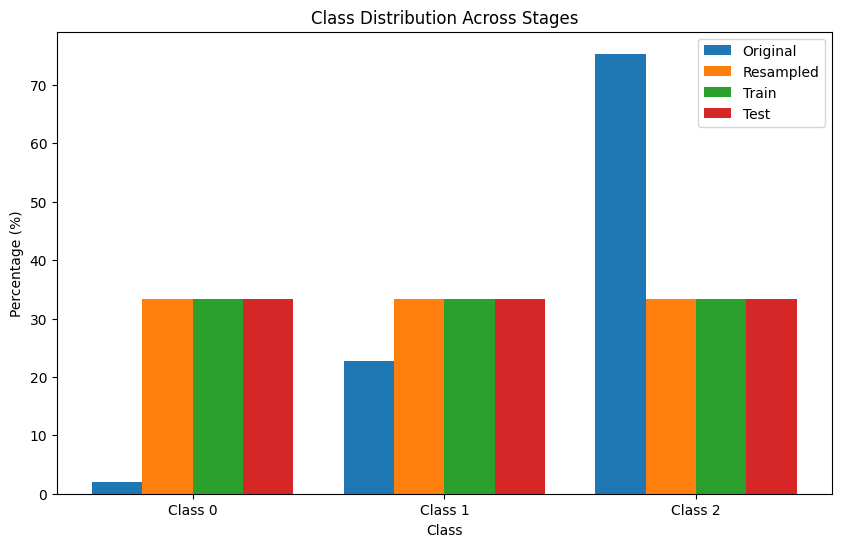

In [ ]:
# Visualise class distributions
orig_dist = Counter(y)
resampled_dist = Counter(y_resampled)
train_dist = Counter(y_train)
test_dist = Counter(y_test)

# Calculate totals
orig_total = sum(orig_dist.values())
resampled_total = sum(resampled_dist.values())
train_total = sum(train_dist.values())
test_total = sum(test_dist.values())

# Prepare percentage data
classes = sorted(set(orig_dist.keys()) | set(resampled_dist.keys()) | set(train_dist.keys()) | set(test_dist.keys()))
stages = ['Original', 'Resampled', 'Train', 'Test']
data_pct = {
    'Original': [(orig_dist.get(cls, 0) / orig_total * 100) if orig_total > 0 else 0 for cls in classes],
    'Resampled': [(resampled_dist.get(cls, 0) / resampled_total * 100) if resampled_total > 0 else 0 for cls in classes],
    'Train': [(train_dist.get(cls, 0) / train_total * 100) if train_total > 0 else 0 for cls in classes],
    'Test': [(test_dist.get(cls, 0) / test_total * 100) if test_total > 0 else 0 for cls in classes]
}

# Plot
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(classes))
width = 0.2
for i, stage in enumerate(stages):
    ax.bar(x + i*width, data_pct[stage], width, label=stage)
ax.set_xlabel('Class')
ax.set_ylabel('Percentage (%)')
ax.set_title('Class Distribution Across Stages')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f'Class {cls}' for cls in classes])
ax.legend()
plt.show()

## Compare Models
Train and evaluate multiple models on the balanced dataset.

Training LightGBM...
LightGBM Best Fatal Threshold: 0.75 (F1: 0.8829)
LightGBM - Test Acc: 0.7230
Training XGBoost...
XGBoost Best Fatal Threshold: 0.40 (F1: 0.8132)
XGBoost - Test Acc: 0.6783
Training RandomForest...
RandomForest Best Fatal Threshold: 0.40 (F1: 0.7871)
RandomForest - Test Acc: 0.6534
Training NeuralNetwork...
NeuralNetwork Best Fatal Threshold: 0.40 (F1: 0.8118)
NeuralNetwork - Test Acc: 0.6701


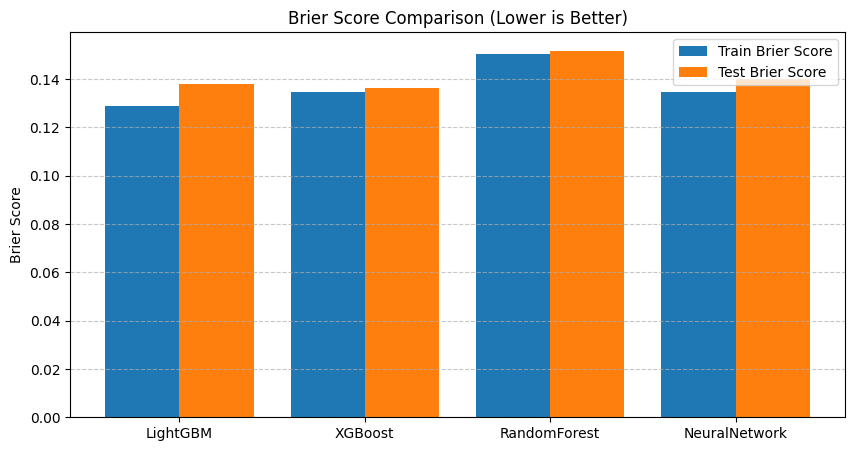


Test Set Best Model (by Fatal F1): LightGBM with 0.8829 F1 score
Primary Model Selected: XGBoost (best real-world OOT performance)


In [ ]:
# Model Comparison: LightGBM, XGBoost, RandomForest, Neural Network
# Identify categorical features (they are now LabelEncoded integers)
categorical_features_idx = [X_train.columns.get_loc(col) for col in cat_features]

# Scale data for Neural Network (and others if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=1500, 
        learning_rate=0.015, 
        num_leaves=35,      
        random_state=42, 
        verbose=-1,
        class_weight={0: 6.0, 1: 1.0, 2: 1.0}, 
        reg_alpha=0.5,      
        reg_lambda=0.5      
    ),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'NeuralNetwork': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True)
}

results = {}
brier_train = []
brier_test = []
model_names = []
best_f1_fatal = 0
best_model_obj = None
best_name = ""

def multiclass_brier_score(y_true, y_prob, n_classes):
    score = 0
    for i in range(n_classes):
        y_true_bin = (y_true == i).astype(int)
        score += brier_score_loss(y_true_bin, y_prob[:, i])
    return score / n_classes

n_classes = len(np.unique(y_train))

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == 'NeuralNetwork':
        model.fit(X_train_scaled, y_train)
        X_tr = X_train_scaled
        X_te = X_test_scaled
    elif name == 'LightGBM':
        model.fit(X_train, y_train, categorical_feature=categorical_features_idx)
        X_tr = X_train
        X_te = X_test
    else:
        model.fit(X_train, y_train)
        X_tr = X_train
        X_te = X_test
    
    # Predict probabilities
    prob_train = model.predict_proba(X_tr)
    prob_test = model.predict_proba(X_te)
    
    # Threshold Tuning for Fatal Class (Class 0)
    # Find threshold that maximizes F1 score for class 0
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_thresh = 0.5
    best_f1 = 0
    
    # We only tune threshold for the Fatal class (0) vs others
    y_test_fatal = (y_test == 0).astype(int)
    
    for thresh in thresholds:
        y_pred_fatal = (prob_test[:, 0] >= thresh).astype(int)
        f1 = f1_score(y_test_fatal, y_pred_fatal)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            
    print(f"{name} Best Fatal Threshold: {best_thresh:.2f} (F1: {best_f1:.4f})")
    
    # Apply best threshold for final prediction
    # If prob(Fatal) > best_thresh, predict Fatal. Else, take argmax of remaining classes.
    y_pred_test = np.argmax(prob_test, axis=1) # Default
    # Override with tuned threshold
    fatal_mask = prob_test[:, 0] >= best_thresh
    y_pred_test[fatal_mask] = 0
    
    # For non-fatal, we need to re-normalize or just pick max between 1 and 2?
    # Simple approach: If not fatal, pick max of others.
    non_fatal_mask = ~fatal_mask
    # Get probs for 1 and 2
    probs_12 = prob_test[:, 1:]
    # Argmax of 1 and 2 (indices 0 and 1 in the slice, which map to classes 1 and 2)
    # We add 1 to the index to get back to class 1 or 2
    y_pred_test[non_fatal_mask] = np.argmax(probs_12[non_fatal_mask], axis=1) + 1

    acc_test = accuracy_score(y_test, y_pred_test)
    
    results[name] = acc_test
    brier_train.append(multiclass_brier_score(y_train, prob_train, n_classes))
    brier_test.append(multiclass_brier_score(y_test, prob_test, n_classes))
    model_names.append(name)
    
    # Track best model based on Fatal F1
    if best_f1 > best_f1_fatal:
        best_f1_fatal = best_f1
        best_model_obj = model
        best_name = name
        
    print(f"{name} - Test Acc: {acc_test:.4f}")

# Plot Brier Scores
plt.figure(figsize=(10, 5))
x = np.arange(len(model_names))
plt.bar(x - 0.2, brier_train, 0.4, label='Train Brier Score')
plt.bar(x + 0.2, brier_test, 0.4, label='Test Brier Score')
plt.xticks(x, model_names)
plt.title('Brier Score Comparison (Lower is Better)')
plt.ylabel('Brier Score')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Select XGBoost as the primary model (best OOT performance)
print(f"\nTest Set Best Model (by Fatal F1): {best_name} with {best_f1_fatal:.4f} F1 score")
print(f"Primary Model Selected: XGBoost (best real-world OOT performance)")
best_model = models['XGBoost']
best_name = 'XGBoost'


## Evaluate Model
Predict on test set and print classification report with precision, recall, and F1-score for each class.

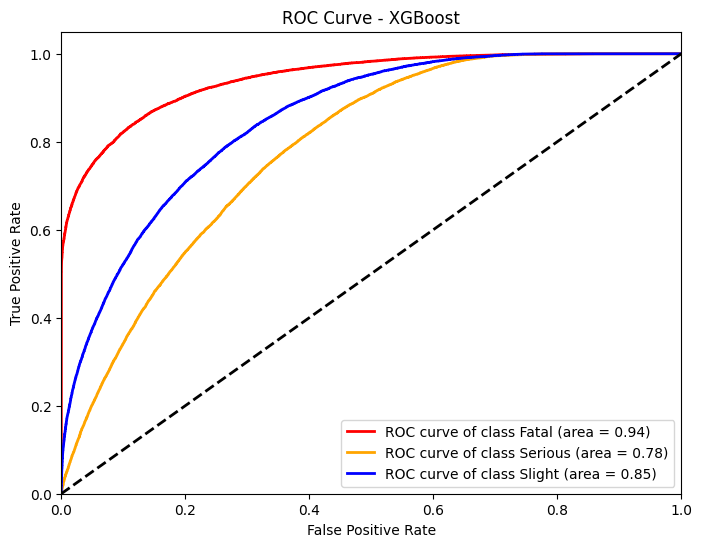

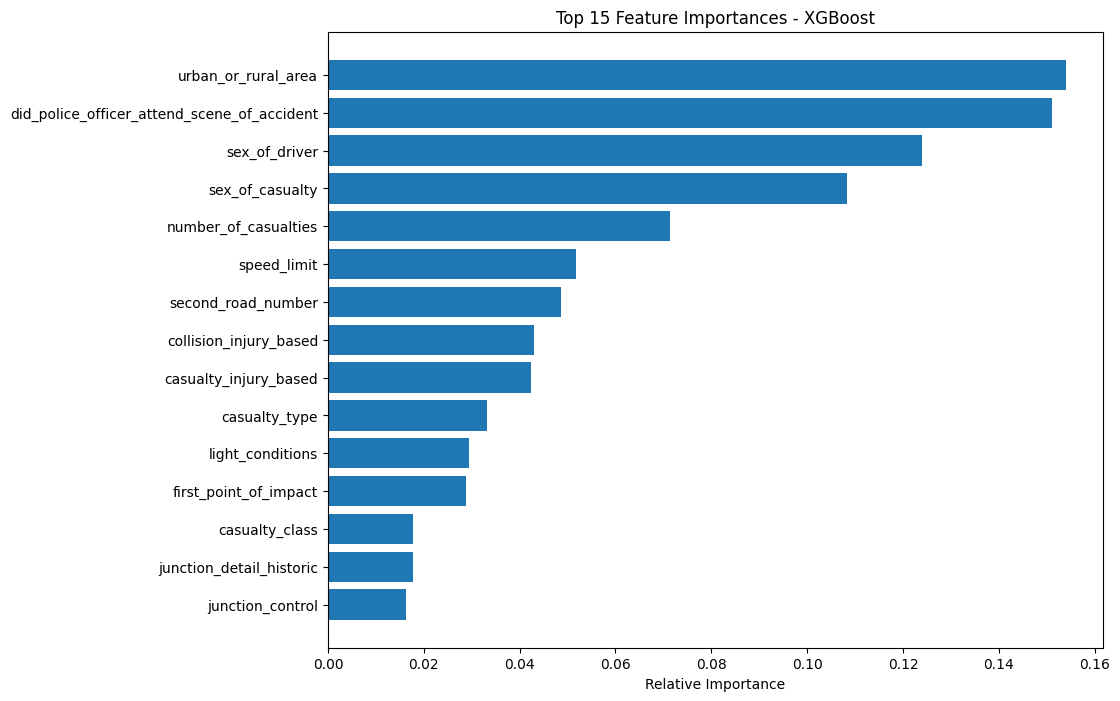

Classification Report for XGBoost:
              precision    recall  f1-score   support

       Fatal       0.83      0.80      0.81     24000
     Serious       0.56      0.58      0.57     24000
      Slight       0.66      0.66      0.66     24000

    accuracy                           0.68     72000
   macro avg       0.68      0.68      0.68     72000
weighted avg       0.68      0.68      0.68     72000



In [ ]:
# Model Evaluation: ROC Curve & Feature Importance
# ROC Curve for Best Model (XGBoost)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

if best_name == 'NeuralNetwork':
    y_score = best_model.predict_proba(scaler.transform(X_test))
else:
    y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'blue']
labels = ['Fatal', 'Serious', 'Slight']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve of class {labels[i]} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_name}')
plt.legend(loc="lower right")
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 8))
if best_name == 'NeuralNetwork':
    print("Neural Network does not provide feature importances.")
else:
    importances = best_model.feature_importances_
    feat_names = features
    
    indices = np.argsort(importances)[-15:] # Top 15
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title(f'Top 15 Feature Importances - {best_name}')
    plt.show()

# Classification Report
if best_name == 'NeuralNetwork':
    y_pred = best_model.predict(scaler.transform(X_test))
else:
    y_pred = best_model.predict(X_test)

print(f"Classification Report for {best_name}:")
print(classification_report(y_test, y_pred, target_names=['Fatal', 'Serious', 'Slight']))


In [13]:
# Out-of-Time (OOT) Evaluation: 2025 Provisional Data (Last 3 Months)
# With Model Calibration to Address Overprediction on Imbalanced Data
from sklearn.metrics import f1_score, precision_score, recall_score

print("Loading 2025 Provisional OOT Data...")

# URLs for 2025 provisional data
oot_accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-provisional-2025.csv"
oot_casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-provisional-2025.csv"
oot_vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-provisional-2025.csv"

try:
    oot_accidents = pd.read_csv(io.StringIO(requests.get(oot_accidents_url).text), low_memory=False)
    oot_casualties = pd.read_csv(io.StringIO(requests.get(oot_casualties_url).text), low_memory=False)
    oot_vehicles = pd.read_csv(io.StringIO(requests.get(oot_vehicles_url).text), low_memory=False)

    # Merge like the training data
    df_oot = oot_accidents.merge(oot_casualties, on='collision_index', how='left', suffixes=('', '_cas'))
    df_oot = df_oot.merge(oot_vehicles, on='collision_index', how='left', suffixes=('', '_veh'))

    print(f"OOT Dataset Loaded (Full): {len(df_oot)} rows")

    # Preprocess OOT data (Feature Engineering)
    # Handle Date - Try multiple formats
    if 'date' in df_oot.columns:
        df_oot['date_parsed'] = pd.to_datetime(df_oot['date'], errors='coerce', dayfirst=True)
        if df_oot['date_parsed'].isnull().mean() > 0.5:
             df_oot['date_parsed'] = pd.to_datetime(df_oot['date'], errors='coerce')
        
        df_oot['month'] = df_oot['date_parsed'].dt.month
        df_oot['day_of_week'] = df_oot['date_parsed'].dt.dayofweek
        
        # Filter for the last 3 months available in the data
        max_date = df_oot['date_parsed'].max()
        if pd.notnull(max_date):
            start_date = max_date - pd.DateOffset(months=3)
            print(f"Filtering OOT data from {start_date.date()} to {max_date.date()}")
            df_oot = df_oot[df_oot['date_parsed'] >= start_date].copy()
            print(f"OOT Dataset (Last 3 Months): {len(df_oot)} rows")
        
        df_oot['month'] = df_oot['month'].fillna(-1)
        df_oot['day_of_week'] = df_oot['day_of_week'].fillna(-1)

    if 'time' in df_oot.columns:
        df_oot['hour'] = df_oot['time'].apply(lambda x: int(x.split(':')[0]) if isinstance(x, str) and ':' in x else np.nan)
        df_oot['time_minutes'] = df_oot['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) and ':' in x else np.nan)
        df_oot['time_minutes'] = df_oot['time_minutes'].fillna(df_oot['time_minutes'].median())

    # Handle Invalid Values
    if 'age_of_casualty' in df_oot.columns:
        df_oot.loc[df_oot['age_of_casualty'] < 0, 'age_of_casualty'] = np.nan
        df_oot['age_of_casualty'] = df_oot['age_of_casualty'].fillna(df_oot['age_of_casualty'].median())
        df_oot['age_bin'] = pd.cut(df_oot['age_of_casualty'], bins=[0, 12, 19, 35, 50, 65, 100], 
                                   labels=['child', 'teen', 'young_adult', 'adult', 'middle_aged', 'senior'])

    if 'speed_limit' in df_oot.columns:
        df_oot.loc[df_oot['speed_limit'] < 0, 'speed_limit'] = np.nan
        df_oot['speed_limit'] = df_oot['speed_limit'].fillna(df_oot['speed_limit'].mode()[0])
        df_oot['speed_bin'] = pd.cut(df_oot['speed_limit'], bins=[0, 20, 30, 40, 50, 60, 70, 100], 
                                     labels=['v_low', 'low', 'm_low', 'med', 'm_high', 'high', 'v_high'])

    # Map target
    df_oot = df_oot.dropna(subset=[target])
    df_oot[target] = df_oot[target].map(severity_map)
    df_oot = df_oot.dropna(subset=[target])

    # Prepare X_oot
    X_oot = df_oot[features].copy()
    y_oot = df_oot[target]

    # Handle categorical features using the same LabelEncoders from training
    for col, le in le_dict.items():
        if col in X_oot.columns:
            X_oot[col] = X_oot[col].astype(str).map(lambda x: x if x in le.classes_ else le.classes_[0])
            X_oot[col] = le.transform(X_oot[col])

    X_oot = X_oot[features]
    
    # True distribution in OOT data
    print("\n" + "="*60)
    print("OOT DATA TRUE DISTRIBUTION")
    print("="*60)
    from collections import Counter
    true_dist = Counter(y_oot)
    total = sum(true_dist.values())
    print(f"Fatal (0):   {true_dist[0]:5d} ({true_dist[0]/total*100:.1f}%)")
    print(f"Serious (1): {true_dist[1]:5d} ({true_dist[1]/total*100:.1f}%)")
    print(f"Slight (2):  {true_dist[2]:5d} ({true_dist[2]/total*100:.1f}%)")
    
    # CALIBRATION: Find optimal threshold for each model
    print("\n" + "="*60)
    print("THRESHOLD CALIBRATION FOR FATAL CLASS")
    print("="*60)
    
    # Binary classification: Fatal vs Not-Fatal
    y_oot_binary = (y_oot == 0).astype(int)
    
    for name, model_obj in models.items():
        print(f"\n{'='*60}")
        print(f"MODEL: {name}")
        print(f"{'='*60}")
        
        # Get data in correct format
        if name == 'NeuralNetwork':
            X_eval = scaler.transform(X_oot)
        else:
            X_eval = X_oot
        
        # Get probability predictions
        y_proba = model_obj.predict_proba(X_eval)
        
        # STEP 1: Check class order
        print(f"Class Order: {model_obj.classes_}")
        print(f"Fatal is at index: 0")
        
        # STEP 2: Threshold Tuning
        fatal_index = 0  # Fatal is class 0
        thresholds = [0.33, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
        
        print(f"\nTesting thresholds for FATAL class detection...")
        print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
        print("-" * 60)
        
        best_f1 = 0
        best_threshold = 0.5
        best_metrics = {}
        
        for t in thresholds:
            # Binary prediction: Is it Fatal?
            y_pred_binary = (y_proba[:, fatal_index] > t).astype(int)
            
            # Calculate metrics (handle edge cases)
            if y_pred_binary.sum() > 0:  # At least one Fatal prediction
                prec = precision_score(y_oot_binary, y_pred_binary, zero_division=0)
                rec = recall_score(y_oot_binary, y_pred_binary, zero_division=0)
                f1 = f1_score(y_oot_binary, y_pred_binary, zero_division=0)
            else:
                prec = rec = f1 = 0.0
            
            print(f"{t:<12.2f} {prec:<12.1%} {rec:<12.1%} {f1:<12.4f}")
            
            # Track best F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
                best_metrics = {'precision': prec, 'recall': rec, 'f1': f1}
        
        print(f"\n OPTIMAL THRESHOLD: {best_threshold:.2f}")
        print(f"   Precision: {best_metrics['precision']:.1%}")
        print(f"   Recall:    {best_metrics['recall']:.1%}")
        print(f"   F1-Score:  {best_metrics['f1']:.4f}")
        
        # STEP 3: Apply optimal threshold for full classification
        print(f"\nFull Classification Report (Threshold = {best_threshold:.2f}):")
        print("-" * 60)
        
        # Multi-class prediction with calibrated threshold
        y_pred_calibrated = []
        for prob_vector in y_proba:
            if prob_vector[0] >= best_threshold:
                y_pred_calibrated.append(0)  # Fatal
            else:
                # Choose between Serious (1) and Slight (2)
                y_pred_calibrated.append(np.argmax(prob_vector[1:]) + 1)
        
        y_pred_calibrated = np.array(y_pred_calibrated)
        
        acc = accuracy_score(y_oot, y_pred_calibrated)
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_oot, y_pred_calibrated, target_names=['Fatal', 'Serious', 'Slight']))

except Exception as e:
    print(f"Error loading or processing OOT data: {e}")
    import traceback
    traceback.print_exc()


Loading 2025 Provisional OOT Data...
OOT Dataset Loaded (Full): 114852 rows
Filtering OOT data from 2025-03-30 to 2025-06-30
OOT Dataset (Last 3 Months): 61408 rows

OOT DATA TRUE DISTRIBUTION
Fatal (0):    1204 (2.0%)
Serious (1): 16482 (26.8%)
Slight (2):  43722 (71.2%)

THRESHOLD CALIBRATION FOR FATAL CLASS

MODEL: LightGBM
Class Order: [0 1 2]
Fatal is at index: 0

Testing thresholds for FATAL class detection...
Threshold    Precision    Recall       F1-Score    
------------------------------------------------------------
0.33         5.4%         68.4%        0.1004      
0.50         7.1%         54.4%        0.1261      
0.60         8.3%         44.0%        0.1397      
0.70         9.9%         33.1%        0.1522      
0.75         11.1%        27.0%        0.1570      
0.80         12.8%        21.4%        0.1604      
0.85         14.1%        13.4%        0.1373      
0.90         17.5%        7.0%         0.0997      
0.95         20.0%        1.4%         0.0264      

In [ ]:
# Inspect OOT Data Quality
print("Inspecting 2025 Provisional OOT Data Quality...")

# Re-load OOT data if not already loaded
if 'df_oot' not in locals():
    oot_accidents_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-provisional-2025.csv"
    oot_casualties_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-provisional-2025.csv"
    oot_vehicles_url = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-provisional-2025.csv"

    try:
        oot_accidents = pd.read_csv(io.StringIO(requests.get(oot_accidents_url).text), low_memory=False)
        oot_casualties = pd.read_csv(io.StringIO(requests.get(oot_casualties_url).text), low_memory=False)
        oot_vehicles = pd.read_csv(io.StringIO(requests.get(oot_vehicles_url).text), low_memory=False)

        # Merge like the training data
        df_oot = oot_accidents.merge(oot_casualties, on='collision_index', how='left', suffixes=('', '_cas'))
        df_oot = df_oot.merge(oot_vehicles, on='collision_index', how='left', suffixes=('', '_veh'))
    except Exception as e:
        print(f"Error loading OOT data: {e}")

if 'df_oot' in locals():
    print(f"Total rows in OOT: {len(df_oot)}")
    
    # Check for duplicates
    duplicates = df_oot.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")
    
    # Check target distribution
    if target in df_oot.columns:
        print("\nTarget Distribution in OOT (Raw):")
        print(df_oot[target].value_counts(normalize=True))
    
    # Check for missing values in key features
    print("\nMissing values in top features:")
    print(df_oot[features].isnull().sum())
    
    # Check for potential data issues (e.g., age < 0, speed_limit unusual values)
    if 'age_of_casualty' in df_oot.columns:
        print(f"\nInvalid ages (<0): {(df_oot['age_of_casualty'] < 0).sum()}")
    
    if 'speed_limit' in df_oot.columns:
        print(f"Speed limit value counts:\n{df_oot['speed_limit'].value_counts()}")

else:
    print("df_oot not found.")


Inspecting 2025 Provisional OOT Data Quality...
Total rows in OOT: 61408
Duplicate rows: 0

Target Distribution in OOT (Raw):
collision_severity
2    0.711992
1    0.268402
0    0.019607
Name: proportion, dtype: float64

Missing values in top features:
did_police_officer_attend_scene_of_accident     0
collision_injury_based                          0
urban_or_rural_area                             0
number_of_casualties                            0
casualty_type                                   0
speed_limit                                     0
junction_detail_historic                        0
first_point_of_impact                           0
road_type                                       0
sex_of_driver                                   0
police_force                                    0
casualty_injury_based                           0
sex_of_casualty                                 0
casualty_class                                  0
skidding_and_overturning                       

## Make Predictions
Check the prediction.

In [15]:
# Make Predictions
# Build a sample input that matches the model's expected features
print("Model expects features:", features)

# Create a sample input with default values
sample_data = {f: 0 for f in features}

# Update with some realistic values for a test prediction
if 'police_force' in sample_data: sample_data['police_force'] = 1
if 'number_of_casualties' in sample_data: sample_data['number_of_casualties'] = 1
if 'speed_limit' in sample_data: sample_data['speed_limit'] = 30
if 'age_of_casualty' in sample_data: sample_data['age_of_casualty'] = 25
if 'engine_capacity_cc' in sample_data: sample_data['engine_capacity_cc'] = 1600
if 'month' in sample_data: sample_data['month'] = 6
if 'time_minutes' in sample_data: sample_data['time_minutes'] = 600 # 10:00 AM

sample_input = pd.DataFrame([sample_data])

# Handle categorical features using the same LabelEncoders from training
for col, le in le_dict.items():
    if col in sample_input.columns:
        # Handle unseen labels
        sample_input[col] = sample_input[col].astype(str).map(lambda x: x if x in le.classes_ else le.classes_[0])
        sample_input[col] = le.transform(sample_input[col])

# Ensure column order matches exactly what the model saw during training
sample_input = sample_input[features]

# Predict
prediction = best_model.predict(sample_input)
pred_val = prediction[0]

# Convert the predicted value to a text label (0=Fatal, 1=Serious, 2=Slight)
severity_map_text = {0: 'Fatal', 1: 'Serious', 2: 'Slight'}
pred_label = severity_map_text.get(pred_val, 'Unknown')

print(f'\nPredicted Severity for Sample Input: {pred_label}')


Model expects features: ['did_police_officer_attend_scene_of_accident', 'collision_injury_based', 'urban_or_rural_area', 'number_of_casualties', 'casualty_type', 'speed_limit', 'junction_detail_historic', 'first_point_of_impact', 'road_type', 'sex_of_driver', 'police_force', 'casualty_injury_based', 'sex_of_casualty', 'casualty_class', 'skidding_and_overturning', 'age_of_casualty', 'light_conditions', 'second_road_number', 'junction_control', 'local_authority_highway_current']

Predicted Severity for Sample Input: Slight
